In [1]:
# Run but do not modify this code
import seaborn as sns
if ('0.11' in sns.__version__) or ('0.12' in sns.__version__):
    sns.set_theme()
else:
    sns.set()

In [2]:
import pandas as pd
sns.set_theme()
tumordata = pd.read_csv("/Users/riahcul/Downloads/Data_Tanzanian-breast_cancer_TILS_Mremi_Hall.csv")
print(tumordata.shape)
tumordata.head()

(323, 18)


,DeID,Ethnicity,Biomarker,TumorType,ER,Her2,Grade,GradeT,GradeN,GradeM,Tsizemm,Age,TILs,mits,Age50,grade1,TILs20,Tsize60
0,1,1,1,ductal,1,0,3,2,3,3,70.0,61,13,18,1,1,0,1
1,2,1,1,ductal,1,0,2,3,2,2,999.0,52,11,13,1,0,0,999
2,3,1,1,mucinous or mucinous fx\t,1,0,1,2,2,1,999.0,65,15,2,1,0,0,999
3,4,1,1,micropap or micropap fx\t,1,0,2,3,2,1,999.0,55,20,7,1,0,0,999
4,5,1,1,cribriform\t,1,0,1,1,2,2,90.0,74,7,13,1,0,0,1


In [3]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

[Text(0.5, 1.0, 'Count of Ethnicities In Data Set'), Text(0, 0.5, 'Count')]

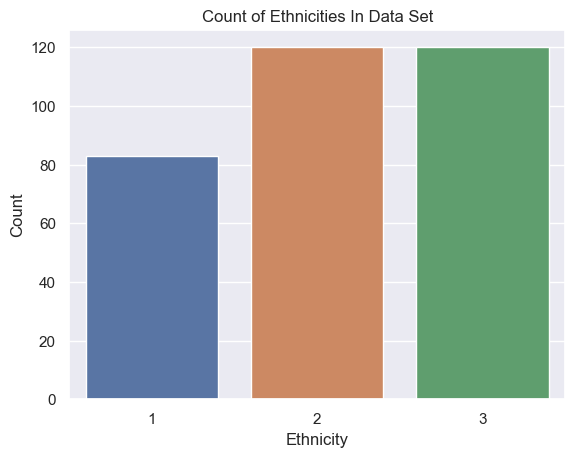

In [4]:
sns.countplot(tumordata, x = "Ethnicity").set(title = "Count of Ethnicities In Data Set", ylabel = "Count")

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


/Users/riahcul/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


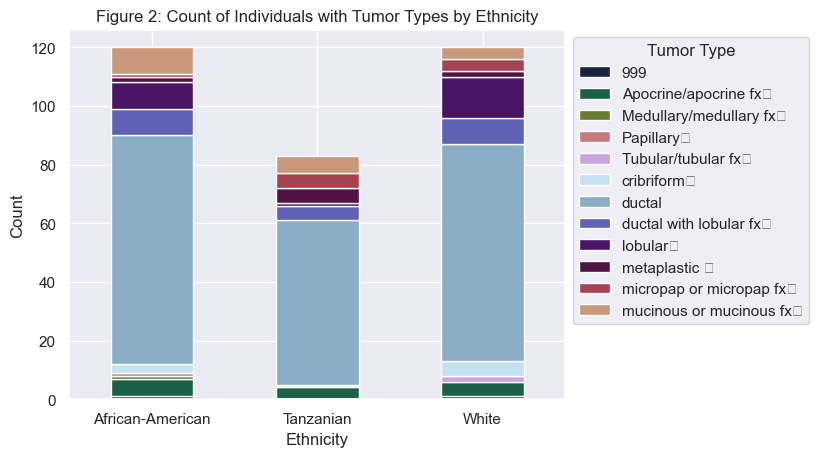

In [5]:
#plt.style.use('seaborn-v0_8')
print(plt.style.available)

tumordata.loc[tumordata["Ethnicity"] == 1, "Ethnicity"] = 'Tanzanian'
tumordata.loc[tumordata["Ethnicity"] == 2, "Ethnicity"] = 'African-American'
tumordata.loc[tumordata["Ethnicity"] == 3, "Ethnicity"] = 'White'

grouped = tumordata.groupby(['Ethnicity', 'TumorType']).size().unstack()

#color_palette = 'Accent'
#num_colors = len(grouped.columns)
#random_colors = sns.color_palette(color_palette, n_colors=num_colors)
color_palette = sns.color_palette("cubehelix") + sns.color_palette("twilight")

#np.random.shuffle(color_palette)

grouped.plot(kind='bar', stacked=True, color = color_palette)
plt.xlabel('Ethnicity')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Figure 2: Count of Individuals with Tumor Types by Ethnicity')
plt.legend(title = "Tumor Type", loc='upper left', bbox_to_anchor=(1, 1))
plt.style.use('ggplot')
plt.show()

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

td = tumordata.copy()
td = td.replace(999, pd.NA)
td = td.dropna()

In [7]:

# Getting data and target
data = td[['TumorType', 'Ethnicity', 'Her2', 'ER', 'Grade']]
target = td['Tsize60'].astype(int)

# Split the data into training and testing sets
train_data, test_data, train_target, test_target = train_test_split(
    data, target, test_size=0.7, random_state=999)

# Fit and transform OneHotEncoder on training data categorical features
one_hot_encoder = OneHotEncoder(handle_unknown='ignore')
train_cat_encoded = one_hot_encoder.fit_transform(train_data[['TumorType', 'Ethnicity']])

# Transform testing data categorical features
test_cat_encoded = one_hot_encoder.transform(test_data[['TumorType', 'Ethnicity']])

# Append encoded categorical features and numerical features
all_train = np.append(train_cat_encoded.toarray(), train_data[['Her2', 'ER', 'Grade']].values, axis=1)
all_test = np.append(test_cat_encoded.toarray(), test_data[['Her2', 'ER', 'Grade']].values, axis=1)


# Train logistic regression model
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')
logistic_model.fit(X=all_train, y=train_target)

# Make predictions on the test set
predictions = logistic_model.predict(all_test)

# Calculate accuracy score
score = accuracy_score(test_target, predictions)
print("Accuracy Score:", score)





Accuracy Score: 0.8888888888888888


Precision: 0.3684210526315789
Recall: 0.4666666666666667
F1-score: 0.4117647058823529
ROC-AUC Score: 0.696969696969697
Confusion Matrix:
[[153  12]
 [  8   7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       165
           1       0.37      0.47      0.41        15

    accuracy                           0.89       180
   macro avg       0.66      0.70      0.68       180
weighted avg       0.90      0.89      0.89       180



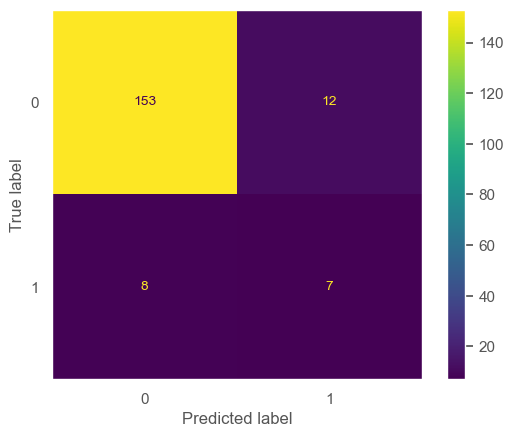

In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
# Calculate precision
precision = precision_score(test_target, predictions)

# Calculate recall
recall = recall_score(test_target, predictions)

# Calculate F1-score
f1 = f1_score(test_target, predictions)

# Calculate ROC-AUC score (only applicable for binary classification)
roc_auc = roc_auc_score(test_target, predictions)

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_target, predictions)
ConfusionMatrixDisplay.from_estimator(estimator = logistic_model, X = all_test, y = test_target)
plt.grid(False)

# Generate classification report
class_report = classification_report(test_target, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC Score:", roc_auc)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'solver': ['liblinear'],  # Solver for logistic regression
}

# Create grid search object
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')

# Fit grid search to the data
grid_search.fit(all_train, train_target)

# Get best hyperparameters
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Best score achieved
best_score = grid_search.best_score_

# Cross-validation results
cv_results = grid_search.cv_results_

print(best_model)


LogisticRegression(C=1, max_iter=1000, solver='liblinear')


In [10]:
np.random.seed(12345678)

# Making a function to use for bootstrapping
def bootstrap(data1, n_bootstrap=10000, ci=95):
    data1 = np.array(data1) 
    indices = np.random.randint(0, len(data1), (n_bootstrap, len(data1)))  
    bootstrap_means = data1[indices].mean(axis=1)  
    lower_bound = np.percentile(bootstrap_means, (100 - ci) / 2) 
    upper_bound = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)  
    return (lower_bound, upper_bound)

ethnicity1_data = td[td['Ethnicity'] == 'Tanzanian']
ethnicity2_data = td[td['Ethnicity'] == 'African-American']
ethnicity3_data = td[td['Ethnicity'] == 'White']

# Get the number of samples for each ethnicity
n1 = len(ethnicity1_data)
n2 = len(ethnicity2_data)
n3 = len(ethnicity3_data)

# Calculate bootstrap confidence intervals for mean tumor size for each ethnicity
interval1 = bootstrap(ethnicity1_data['Tsizemm'])
interval2 = bootstrap(ethnicity2_data['Tsizemm'])
interval3 = bootstrap(ethnicity3_data['Tsizemm'])

print("95% Confidence Interval for Mean Tumor Size for Tanzanian Ethnicity:", interval1)
print("95% Confidence Interval for Mean Tumor Size for African-American Ethnicity:", interval2)
print("95% Confidence Interval for Mean Tumor Size for White Ethnicity:", interval3)


95% Confidence Interval for Mean Tumor Size for Tanzanian Ethnicity: (60.370370370370374, 85.18518518518519)
95% Confidence Interval for Mean Tumor Size for African-American Ethnicity: (20.744827586206892, 27.48364224137931)
95% Confidence Interval for Mean Tumor Size for White Ethnicity: (19.700840707964602, 26.417699115044247)
